In [1]:
import pandas as pd
import requests
from urllib.parse import urlencode
import json, datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
%matplotlib inline

mpl.style.use('seaborn')
api_key = "94bd224fdd23e740f91f7fc88375518f"


In [2]:
from datetime import datetime

def _dict_to_val(_dict):
    try:
        return list(_dict.values())[0]
    except:
        return 0
    
def temp_odcz(temp, wind_speed):
    return 13.12 + 0.6215 * temp - 11.37 * wind_speed**0.16 + 0.3965 * temp * wind_speed**0.16

def temp_pkt_rosy(temp, humidity):
    return (humidity/100)**(1/float(8)) * abs(112 + (0.9 * temp)) + (0.1 * temp) - 112

def getDateFrame(city, date):
    url = 'http://api.openweathermap.org/data/2.5/forecast?q={}&units=metric&APPID={}'.format(city, api_key)
    r = requests.get(url)
    weather = json.loads(r.text)
    df = pd.DataFrame.from_dict(weather['list'])

    df["clouds"] = df.apply(lambda x: x.clouds["all"], axis=1)
    df["rain"] = df.apply(lambda x: _dict_to_val(x.rain) if hasattr(x, 'rain') else 0, axis=1)
    df["snow"] = df.apply(lambda x: _dict_to_val(x.snow), axis=1)
    df["sys"] = df.apply(lambda x: list(x.sys["pod"]), axis=1)
    df["dt_txt1"] = df.apply(lambda x: datetime.strptime(x.dt_txt, '%Y-%m-%d %H:%M:%S'), axis=1)
    df["date"] = df.apply(lambda x: x.dt_txt1.date(), axis=1)
    df["time"] = df.apply(lambda x: x.dt_txt1.time(), axis=1)

    df  = df.merge(df.wind.apply(lambda s: pd.Series({'wind_speed':s["speed"], 'wind_deg':s["deg"]})), 
    left_index=True, right_index=True)
    df = df.merge(df.main.apply(lambda s: pd.Series({'temp':s["temp"], 'temp_min':s["temp_min"], 'temp_max':s["temp_max"], 'pressure': s['pressure'], "sea_level": s["sea_level"], "grnd_level": s["grnd_level"], "humidity": s["humidity"], "temp_kf": s["temp_kf"]})), 
    left_index=True, right_index=True)

    df = df.drop(columns=["main", "wind", "weather", "dt_txt"])

    pd.options.mode.chained_assignment = None  # default='warn'
    pd.set_option('display.max_columns',500)


    df["wind_speed_kmh"] = df.apply(lambda x: x.wind_speed * 3.6, axis=1)
    df["temp_odcz"] = df.apply(lambda row: temp_odcz(row.temp, row.wind_speed), axis=1)
    df["temp_odcz_min"] = df.apply(lambda row: temp_odcz(row.temp_min, row.wind_speed), axis=1)
    df["temp_odcz_max"] = df.apply(lambda row: temp_odcz(row.temp_max, row.wind_speed), axis=1)
    df["temp_pkt_rosy"] = df.apply(lambda row: temp_pkt_rosy(row.temp, row.humidity), axis=1)

    df2 = df.loc[df["date"] == datetime.strptime(date, "%Y-%m-%d").date()]
    return df2

In [3]:
chosenDf = getDateFrame("Warsaw", "2019-01-08")
chosenDf

,clouds,dt,rain,snow,sys,dt_txt1,date,time,wind_speed,wind_deg,temp,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,temp_kf,wind_speed_kmh,temp_odcz,temp_odcz_min,temp_odcz_max,temp_pkt_rosy
9,48,1546905600,0.00,0.0025,[n],2019-01-08 00:00:00,2019-01-08,00:00:00,5.26,194.002,-9.31,-9.31,-9.31,1019.13,1032.28,1019.13,81.0,0.0,18.936,-12.309874,-12.309874,-12.309874,-12.003758
10,92,1546916400,0.00,0.1625,[n],2019-01-08 03:00:00,2019-01-08,03:00:00,5.82,196.005,-6.00,-6.00,-6.00,1014.34,1027.37,1014.34,87.0,0.0,20.952,-8.833633,-8.833633,-8.833633,-7.839609
11,92,1546927200,0.00,0.1525,[n],2019-01-08 06:00:00,2019-01-08,06:00:00,7.01,192.501,-3.14,-3.14,-3.14,1008.83,1021.62,1008.83,90.0,0.0,25.236,-6.058226,-6.058226,-6.058226,-4.568402
12,92,1546938000,0.00,1.5850,[d],2019-01-08 09:00:00,2019-01-08,09:00:00,7.70,202.002,-1.36,-1.36,-1.36,1004.60,1017.29,1004.60,93.0,0.0,27.720,-4.234308,-4.234308,-4.234308,-2.360342
13,92,1546948800,0.00,2.6300,[d],2019-01-08 12:00:00,2019-01-08,12:00:00,6.81,212.503,0.67,0.67,0.67,1000.73,1013.29,1000.73,95.0,0.0,24.516,-1.557322,-1.557322,-1.557322,-0.049663
14,92,1546959600,0.34,0.2775,[n],2019-01-08 15:00:00,2019-01-08,15:00:00,6.51,206.002,1.89,1.89,1.89,997.64,1010.13,997.64,96.0,0.0,23.436,-0.037887,-0.037887,-0.037887,1.311290
15,92,1546970400,0.59,0.0025,[n],2019-01-08 18:00:00,2019-01-08,18:00:00,6.69,193.500,2.00,2.00,2.00,994.91,1007.38,994.91,95.0,0.0,24.084,0.026911,0.026911,0.026911,1.272687
16,92,1546981200,1.18,0.4925,[n],2019-01-08 21:00:00,2019-01-08,21:00:00,6.36,187.003,1.55,1.55,1.55,992.89,1005.38,992.89,97.0,0.0,22.896,-0.377089,-0.377089,-0.377089,1.119081


In [4]:
def plot_temperature(date_df):
    fig, ax = plt.subplots()
    x = date_df["dt_txt1"].dt.hour
    plt.xticks(x)
    minimum = min(date_df['temp_odcz'].min(), date_df['temp_pkt_rosy'].min())
    maximum = max(date_df['temp_odcz'].max(), date_df['temp_pkt_rosy'].max())
    plt.ylim(minimum - 2, 10)
    plt.plot(x, date_df['temp'], 'r', zorder =2) 
    plt.plot(x, date_df['temp_odcz'], 'b')  
    plt.plot(x, date_df['temp_pkt_rosy'], 'm*') 
    plt.grid(True)
    plt.axhspan(minimum - 2, 0, facecolor='#73bdfe', alpha = 0.3)
    plt.show()



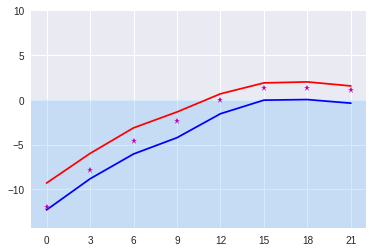

In [ ]:
plot_temperature(chosenDf)

In [ ]:
import math
def get_change(deg, radius):
    rad = math.radians(deg % 360);
    dx = radius * math.cos(rad);
    dy = -radius * math.sin(rad);
    return [dx, dy];

def plot_wind_direction(date_df):
    fig, ax = plt.subplots()
    plt.xlim(-3,24)
    plt.ylim(-15,15)
    x = date_df["dt_txt1"].dt.hour
    plt.xticks(x)

    for hour,deg in zip(x,date_df["wind_deg"]):
        vector = get_change(deg - 90, 3)
        print(hour, deg)
        plt.arrow(hour,  
                  0,
                  vector[0],
                  vector[1], 
                  color="b",
                  head_width = 0.5,
                  head_length = 1)
    plt.show()

0 194.002
3 196.005
6 192.501
9 202.002
12 212.503
15 206.002
18 193.5
21 187.003


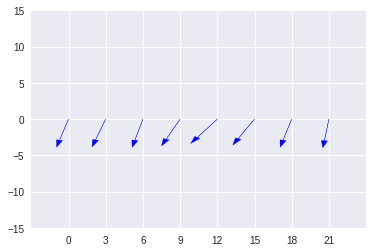

In [ ]:
plot_wind_direction(chosenDf)

In [ ]:
with open("input_data_config.json") as json_data:
    d = json.load(json_data)
    data = pd.DataFrame.from_dict(d['list'])
data

,city_name,x,y
0,Warsaw,680,435
1,Gdańsk,440,80
2,Szczecin,50,220
3,Olsztyn,615,170
4,Bydgoszcz,380,285
5,Białystok,880,270
6,Poznań,270,390
7,Gorzów wielkopolski,110,340
8,Lublin,840,590
9,Łódź,520,510


Warsaw 197.93975
Gdańsk 183.25225
Szczecin 269.93975
Olsztyn 183.56475
Bydgoszcz 220.68975
Białystok 188.12725
Poznań 248.06474999999998
Gorzów wielkopolski 260.87725
Lublin 198.56475
Łódź 220.50225
Wrocław 243.37724999999998
Opole 229.93975
Katowice 225.50225
Kraków 212.31475
Kielce 217.87725
Rzeszów 198.37725


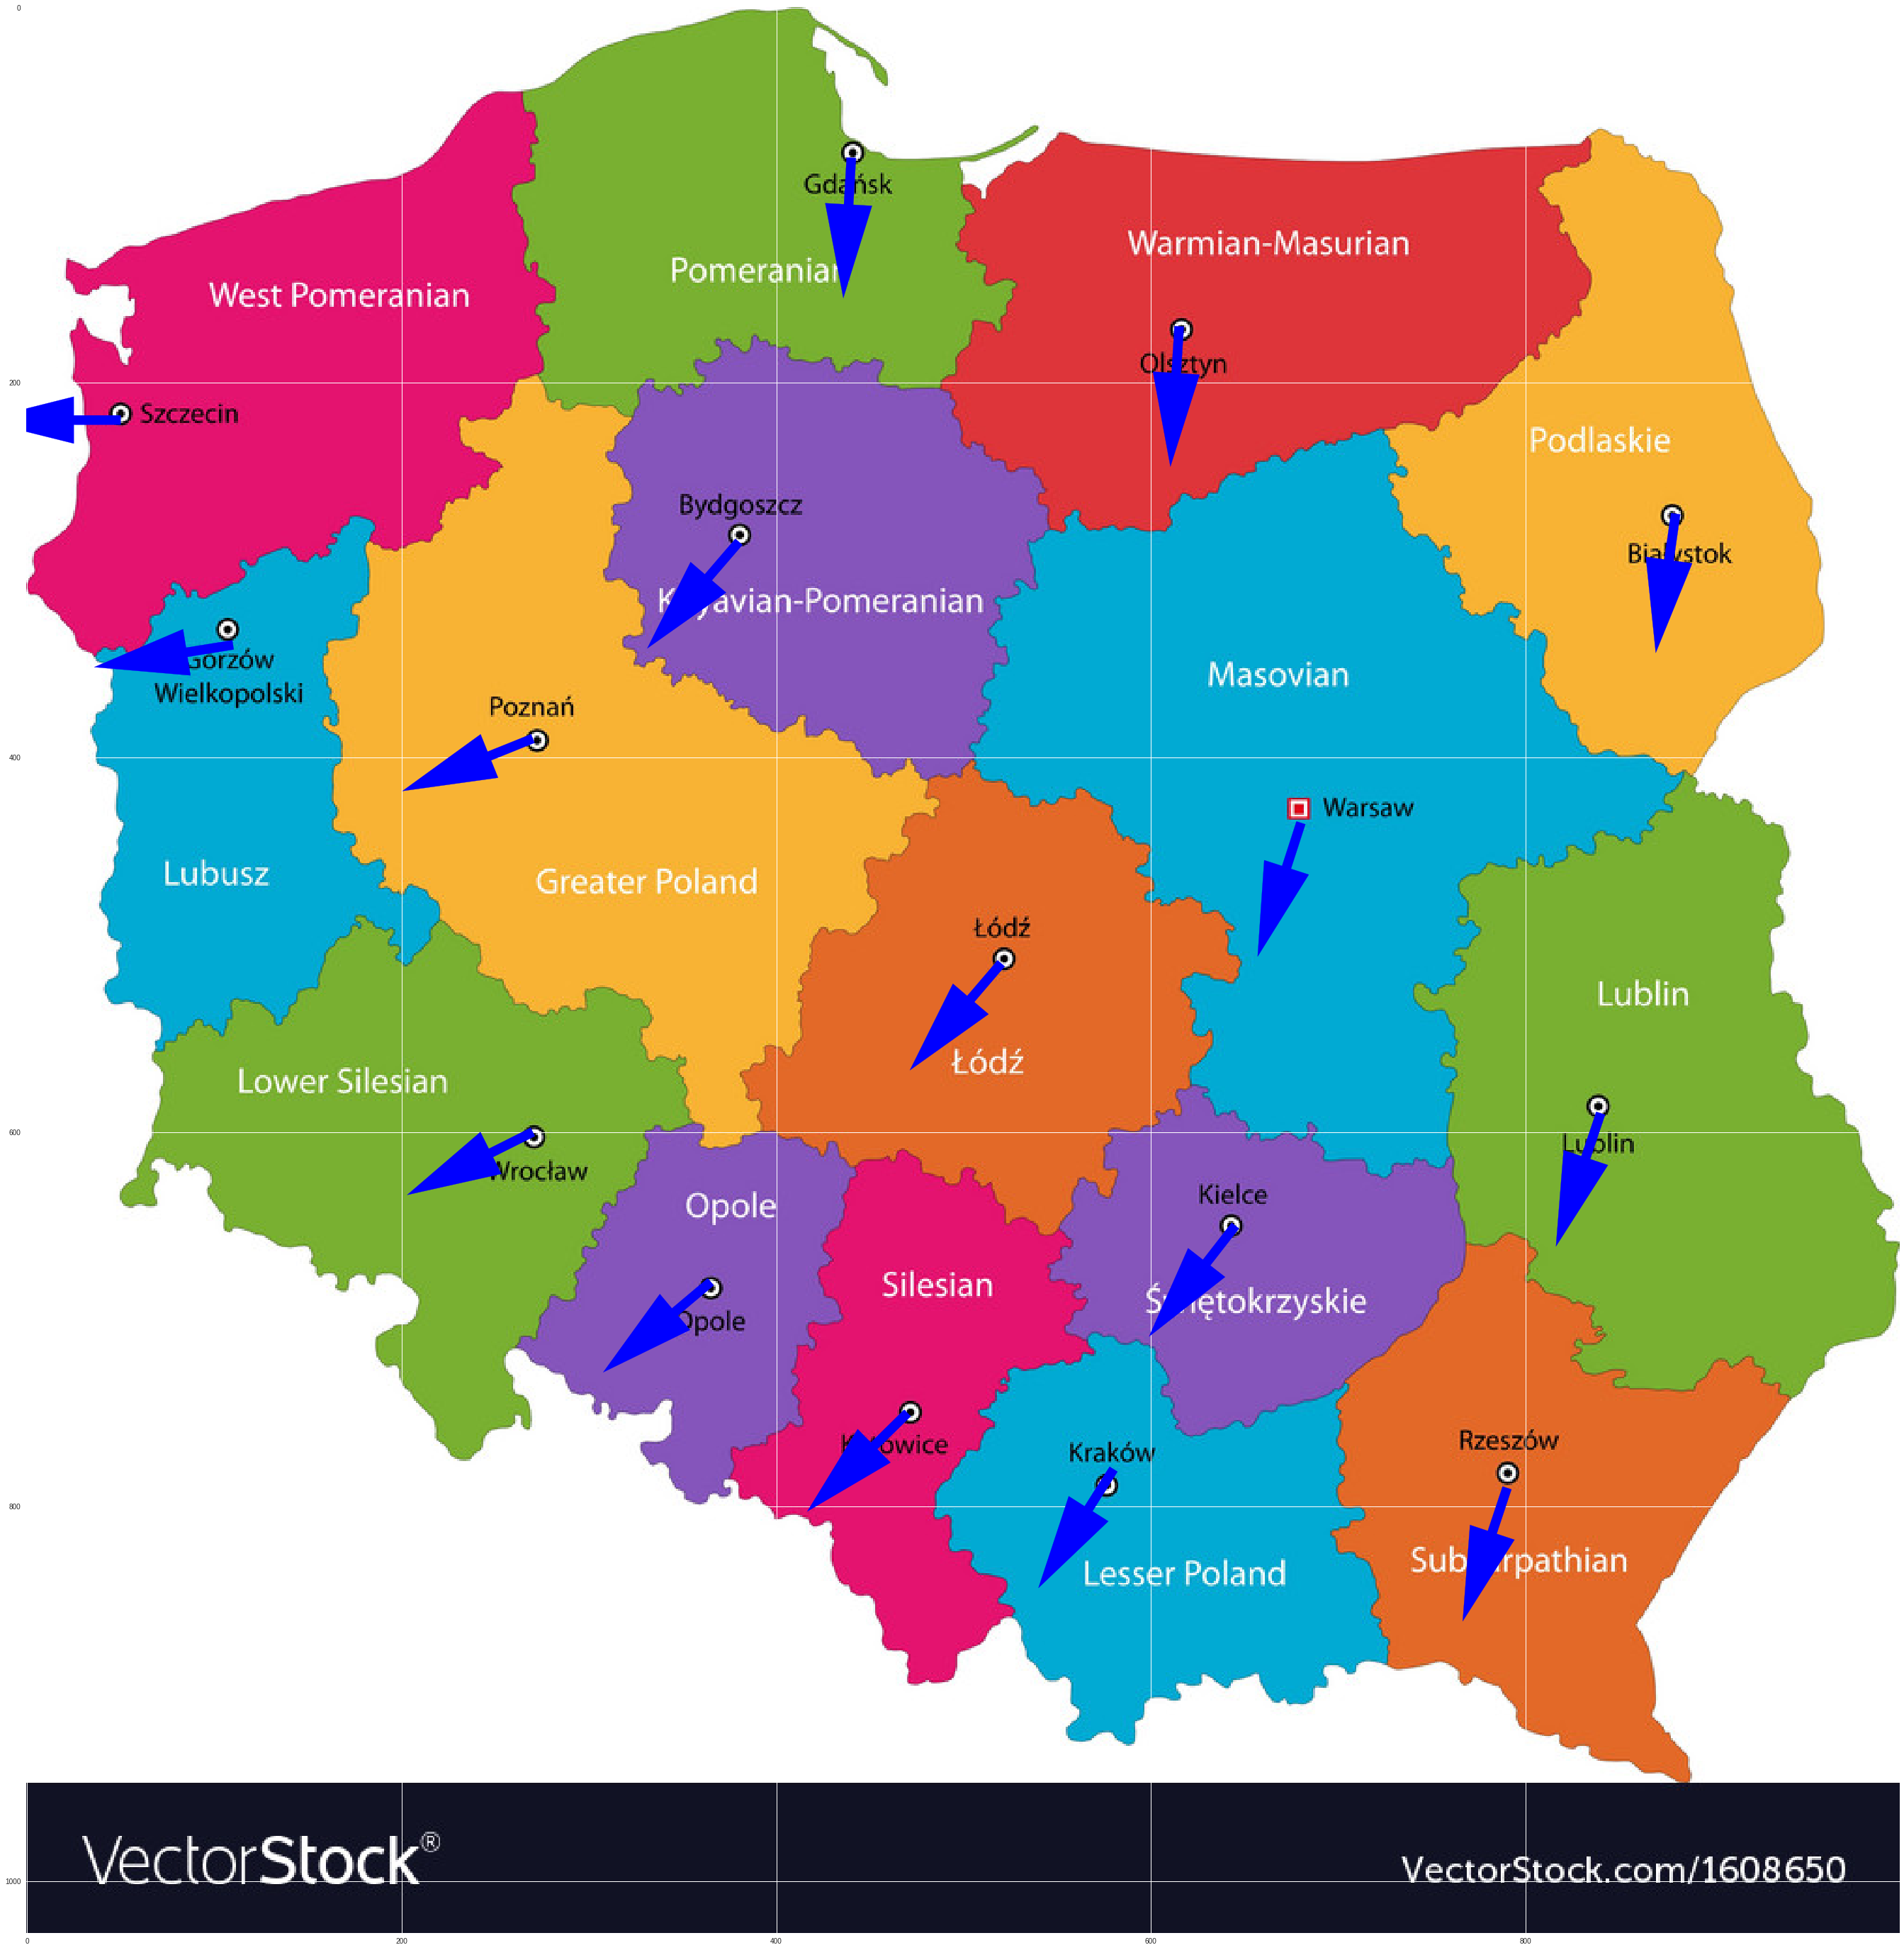

In [ ]:
img = plt.imread("poland.jpg")
fig, ax = plt.subplots()
fig.set_size_inches(50,50)
for city,x,y in zip(data["city_name"], data["x"], data["y"]):
    df = getDateFrame(city, "2019-01-08")
    deg = df["wind_deg"].mean()
    vector = get_change(deg - 90, 25)
    print(city,deg)
    ax.arrow(x,  
             y,
             vector[0],
             -vector[1], 
             width = 5,
             color="b",
             head_width = 25,
             head_length = 50)
ax.imshow(img)
fig.savefig("poland_plane.jpg")

In [ ]:
import vtk
import math


ren = vtk.vtkRenderer()
renWin = vtk.vtkRenderWindow()
renWin.AddRenderer(ren)
renWin.SetSize(800,800)
iren = vtk.vtkRenderWindowInteractor()
iren.SetRenderWindow(renWin)

plane = vtk.vtkPlaneSource()
plane.SetCenter(0.0, 0.0, 0.0)
plane.SetNormal(0.0, 0.0, 0.0)

reader = vtk.vtkJPEGReader()
reader.SetFileName("poland_plane.jpg")

map_to_plane = vtk.vtkTextureMapToPlane()
map_to_plane.SetInputConnection(plane.GetOutputPort())


mapper = vtk.vtkPolyDataMapper()
mapper.SetInputConnection(map_to_plane.GetOutputPort())



texture = vtk.vtkTexture()
texture.SetInputConnection(reader.GetOutputPort())

actor = vtk.vtkActor()
actor.SetMapper(mapper)
actor.SetTexture(texture)



ren.AddActor(actor)

iren.Initialize()
renWin.Render()
iren.Start()
